In [1]:
#Testing
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import math
import ruptures as rpt
import warnings
import holidays
from hijri_converter import convert
from datetime import date,datetime, timedelta
from prophet.diagnostics import performance_metrics, cross_validation


warnings.filterwarnings("ignore")

## Parameters

In [2]:
growth='linear'
country_name='SA'
interval_width=0.95
seasonality_mode='multiplicative'
seasonality_mode=seasonality_mode
yearly_seasonality=6
mcmc_samples=2

#holidays = 'df_weekends'

changepoint_prior_scale=0.08

monthly_season='monthly'
monthly_season_period=30.5
monthly_season_fourier_order=10
monthly_season_mode='additive'

#Weekend
start_date ='01-01-2018'
end_date = '01-01-2024'
weekend_days = [4]  #4 is Friday:  0-6:Mon-Sun


In [3]:
# Load and prepare the data for Prophet
df = pd.read_csv('/home/ajaz/DemandForecasting/Data/data.csv')
data = df.rename(columns={'TransactionDate': 'ds', 'GroupCostPrice': 'y'})
data = data[['ds', 'y']]
data['ds']=pd.to_datetime(data['ds'])
#data.head(2)

### Parameter  Growth  

In [4]:
# Function to decide whether data['y'] is logistic or linear

def detect_growth_pattern(data, curvature_threshold=0.1):
    # Calculate second derivative (curvature)
    curvature = np.gradient(np.gradient(data))
    # Check if the curvature is close to zero
    if np.abs(np.mean(curvature)) <= curvature_threshold:
        return 'linear'
    else:
        return 'logistic'
    
# Detect growth pattern
growth = detect_growth_pattern(data['y'])

# Define a percentile value (e.g., 99th percentile)
percentile_value = 99

# Calculate the specified percentile for the cap
cap = (np.percentile(data['y'], percentile_value)) * 1.5

# Define a lower percentile value (e.g., 5th percentile) for the floor
percentile_floor = 5

# Calculate the specified percentile for the floor
floor = np.percentile(data['y'], percentile_floor)
#floor and cap can be used while predicting we need to add them in future_dataframe'
#print('Parameter : growth=' +growth)

### Parameter 2: Change points PELT Algo

In [5]:
def calculate_penalty(data, sensitivity, cal=[6, 3, 1.5]):
    if sensitivity == "Low":
        return cal[0] * math.log(len(data))
    elif sensitivity == "Medium":
        return cal[1] * math.log(len(data))
    elif sensitivity == "High":
        return cal[2] * math.log(len(data))

In [6]:
peltdata = data['y'].values
# You can choose between "l1" and "l2" cost functions
model = "l1"  

algo = rpt.Pelt(model=model, min_size=1, jump=1).fit(peltdata) 
penalty= calculate_penalty(peltdata, "Medium") 
result = algo.predict(pen=3) 

changepointDates=[]
for index in result:
    a=data.iloc[index-1]['ds']
    changepointDates.append(a)

changepointDates=pd.DataFrame(changepointDates, columns=['ds'])
changepointDates['ds'] = pd.to_datetime(changepointDates['ds'])

changepoints=changepointDates['ds']     
#holidays=holidays
#changepointDates.head(2)

# Outlier

In [7]:
# Assuming you have calculated Q1, Q3, IQR, lower_bound, and upper_bound
# as per the previous snippet
Q1 = data['y'].quantile(0.25)
Q3 = data['y'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

soutliers = data[((data['y'] < lower_bound) | (data['y'] > upper_bound))]

# Identifying outliers
outliers = data[((data['y'] < lower_bound) | (data['y'] > upper_bound))]

# Replace outlier values with the mean
data.loc[outliers.index, 'y'] = data['y'].mean()

# Optional: Print the updated DataFrame
#data.head(2)

## Ramadan Holidays

In [8]:
def generate_ramadan_dates_df(start_year, end_year):
    ramadan_dates = []

    for year in range(start_year, end_year + 1):
        # The Umm al-Qura calendar uses Hijri dates for Islamic months
        hijri_year_start = convert.Gregorian(year, 1, 1).to_hijri()
        hijri_year_end = convert.Gregorian(year, 12, 30).to_hijri()

        for day in range(1, 30):  # Assuming Ramadan lasts for 29 or 30 days
            # Find the date of Ramadan in the Hijri calendar
            ramadan_date = convert.Hijri(hijri_year_start.year, 9, day).to_gregorian()

            # Append the date to the list
            ramadan_dates.append(ramadan_date)

    # Create a DataFrame with a column named 'ramadan_dates'
    ramadan_df = pd.DataFrame({'ds': ramadan_dates})
    return ramadan_df

In [9]:
start_year = datetime.strptime(start_date, '%d-%m-%Y').year
end_year = datetime.strptime(end_date, '%d-%m-%Y').year
ramadan_df = generate_ramadan_dates_df(start_year, end_year)

## Weekend

In [10]:
def generate_weekends(start_date, end_date, weekend_days):
    start_date = datetime.strptime(start_date, '%d-%m-%Y')
    end_date = datetime.strptime(end_date, '%d-%m-%Y')
    
    weekends = []
    current_date = start_date

    while current_date <= end_date:
        # Check if the current date is a weekend
        if current_date.weekday() in weekend_days:
            weekends.append(current_date)
        current_date += timedelta(days=1)

    # Create a DataFrame with day names and dates
    weekend_df = {'ds': weekends,
                  'holiday': [day.strftime('%A') for day in weekends]}

    df_weekends = pd.DataFrame(weekend_df)
    return df_weekends

In [11]:
df_weekends = generate_weekends(start_date, end_date, weekend_days)
df_weekends 

,ds,holiday
0,2018-01-05,Friday
1,2018-01-12,Friday
2,2018-01-19,Friday
3,2018-01-26,Friday
4,2018-02-02,Friday
...,...,...
308,2023-12-01,Friday
309,2023-12-08,Friday
310,2023-12-15,Friday
311,2023-12-22,Friday


## Adding Extra Columns To dataframe

In [12]:
# Create a binary indicator for Ramadan
data['is_ramadan'] = data['ds'].isin(ramadan_df['ds']).astype(int)
prophet_data= data
prophet_data['cap']=cap
prophet_data['floor']=floor

# Training

### Fitting the Model

In [13]:

model = Prophet(
                growth=growth  
                #,mcmc_samples=300
                ,
                holidays=df_weekends
                ,holidays_prior_scale=0.25
                ,changepoint_prior_scale=0.10
                ,seasonality_mode='multiplicative'
                ,yearly_seasonality=10
                ,weekly_seasonality=True
                ,daily_seasonality=False
                
                )



''' 
model = Prophet(
               # growth=growth  
               # ,
                changepoints=changepoints   
                ,interval_width=interval_width
                ,holidays=df_weekends
               )
'''
model.add_country_holidays(country_name=country_name)



model.add_seasonality(
                 name='Monthly_Ramadan_season'
                ,period=29.53
                ,fourier_order=10
                ,condition_name='is_ramadan'
                )



model.fit(prophet_data)

11:55:07 - cmdstanpy - INFO - Chain [1] start processing
11:55:07 - cmdstanpy - INFO - Chain [1] done processing


# Generate future dates

In [14]:
### Generate future dates

future_df = model.make_future_dataframe(periods=30)
future_df['is_ramadan'] = future_df['ds'].isin(ramadan_df['ds']).astype(int)
future_df['cap'] = cap
future_df['floor'] = floor

# Add the 'holidays' column to the future DataFrame
future_df['holidays'] = 0
future_df.loc[future_df['ds'].isin(df_weekends['ds']), 'holidays'] = 1

### Generate predictions
forecast = model.predict(future_df)

### Analyze and visualize results
forecast=forecast[['ds', 'yhat']].tail(30)# View predicted values for the next 30 days
forecast.to_csv('/home/ajaz/DemandForecasting/Data/Output/forecast.csv')
 
#print('Sucessfully Exported')

In [15]:
future_df

,ds,is_ramadan,cap,floor,holidays
0,2018-01-01,0,331830.048,0.0,0
1,2018-01-02,0,331830.048,0.0,0
2,2018-01-03,0,331830.048,0.0,0
3,2018-01-04,0,331830.048,0.0,0
4,2018-01-05,0,331830.048,0.0,1
...,...,...,...,...,...
2063,2023-08-26,0,331830.048,0.0,0
2064,2023-08-27,0,331830.048,0.0,0
2065,2023-08-28,0,331830.048,0.0,0
2066,2023-08-29,0,331830.048,0.0,0


In [16]:
#future_df.head(2)

In [17]:
#fig = model.plot(model.predict(future_df))

## Cross Validation

In [18]:
#df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '30 days')
#df_p = performance_metrics(df_cv)
#df_p.head(2)

In [19]:
#df_p = performance_metrics(df_cv)
## Mean MAPE across all horizons
#overall_mape = np.mean(df_p['smape'])
# Median MAPE (more robust to outliers)
#overall_mape_median = np.median(df_p['smape'])
#print('Sucessfully Exported')
# print(overall_mape_median)

# Comparision of ACtual And predicted Data

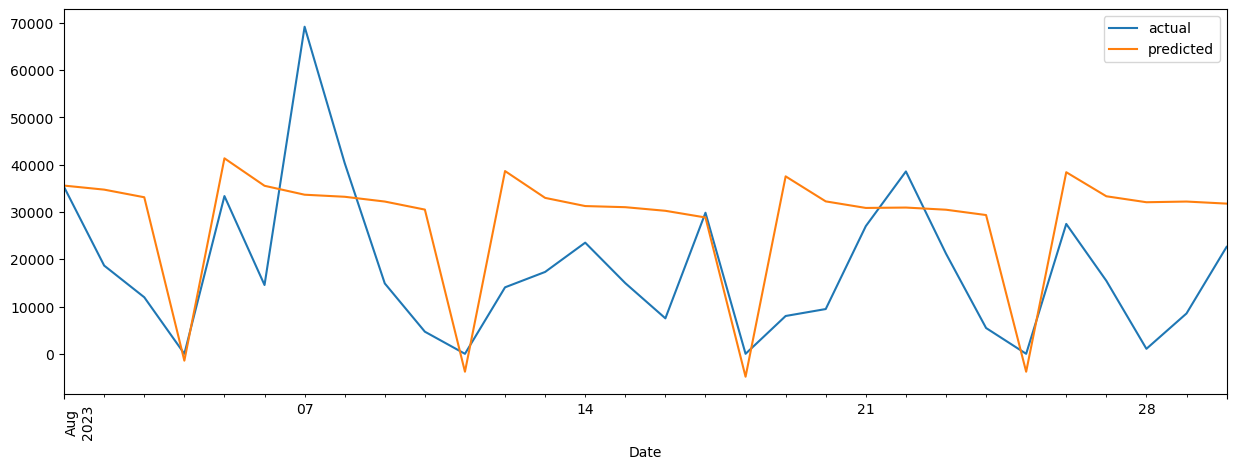

In [20]:
#Create comment for the following code

actualdata = pd.read_csv('/home/ajaz/DemandForecasting/Data/actualdata.csv')
actualdata = actualdata.rename(columns={'TransactionDate': 'ds', 'GroupCostPrice': 'actual'})
actualdata['ds']=pd.to_datetime(actualdata['ds'])


predicteddata =forecast[['ds', 'yhat']].tail(30)
predicteddata = predicteddata.rename(columns={'ds': 'ds', 'yhat': 'predicted'})
predicteddata['ds']=pd.to_datetime(predicteddata['ds'])

finaldata = pd.merge(actualdata,predicteddata,on='ds')
finaldata.plot(x='ds', y=['actual', 'predicted'], kind='line')
#show the day name x axis
plt.xticks(rotation=90)
plt.xlabel('Date')
fig = plt.gcf()
fig.set_size_inches(15, 5)

#finaldata.to_csv('/home/ajaz/DemandForecasting/Data/final.csv')